In [1]:
import yfinance as yf
import pandas as pd
import sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams["figure.figsize"] = [20, 6]

C:\Users\acer\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\acer\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\acer\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# download stock values and compute returns

apl = yf.Ticker("AAPL")
apple = apl.history(start="2015-01-04", end="2021-09-01", interval="1d")

returns = apple["Close"] + apple["Dividends"]
returns.dropna()

Date
2015-01-05     24.083960
2015-01-06     24.086231
2015-01-07     24.423967
2015-01-08     25.362392
2015-01-09     25.389595
                 ...    
2021-08-25    148.360001
2021-08-26    147.539993
2021-08-27    148.600006
2021-08-30    153.119995
2021-08-31    151.830002
Length: 1677, dtype: float64

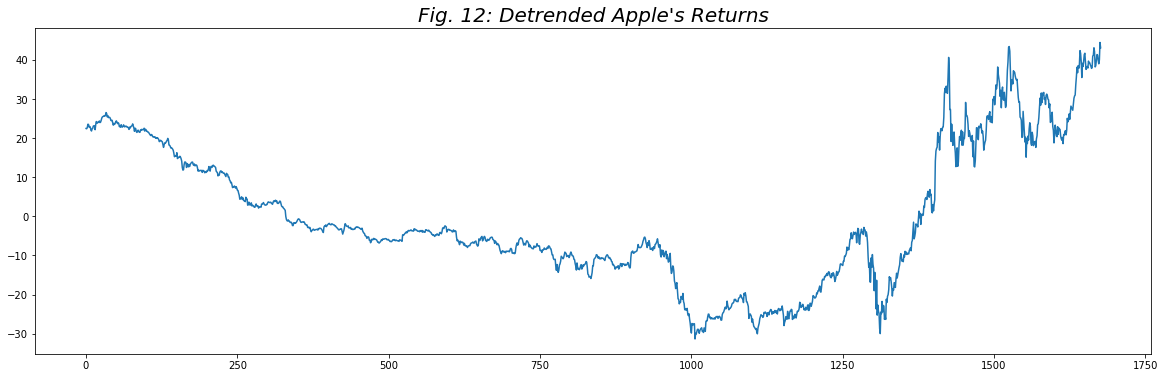

In [3]:
# let's try to extrapolate an eventual trend before differencing

from statsmodels.tsa.seasonal import seasonal_decompose

# Using scipy: Subtract the line of best fit
from scipy import signal
array_detrended = signal.detrend(returns.values)
plt.plot(array_detrended)
plt.title("Fig. 12: Detrended Apple's Returns", fontsize=20, fontstyle = 'italic')

# make np.array into a pd.DataFrame
detrended = pd.DataFrame(array_detrended)

In [4]:
# now differentiate the detrended series

detrended_diff = detrended.diff()

det_diff=detrended_diff.dropna() # the first value would be a na

# plt.plot(det_diff)
# plt.show()

In [46]:
# ADF to control on detrended and differentiated series

from statsmodels.tsa.stattools import adfuller

X = det_diff.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.846811
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [47]:
# series is stationary, now ARIMA (p,1,q) from Statsmodels

In [48]:
# ARIMA statsmodel

# load statsmodels
import statsmodels.tsa.arima_model as stm
import warnings
warnings.filterwarnings("ignore")

from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

In [49]:
# The classical approach for fitting an ARIMA model 
# is to follow the Box-Jenkins Methodology.

In [50]:
# transforms x (det_diff) from a pd.DataFrame into V (that is an Array)
x = det_diff
V = x.values 

In [51]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    # V = det_diff.values
    size = int(len(V) * 0.9)
    train, test = V[0:size], V[size:len(V)]
    history = [i for i in train]
 
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [52]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [53]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [41]:
# evaluate parameters
p_values = range(0, 3) # seek for PACF
d_values = [1] # depends on the differentiation, in apple = 1
q_values = range(0, 3) # seek for ACF
warnings.filterwarnings("ignore")
evaluate_models(det_diff.values, p_values, d_values, q_values)

ARIMA(0, 1, 0) MSE=2.934
ARIMA(0, 1, 1) MSE=1.973
ARIMA(0, 1, 2) MSE=1.962
ARIMA(1, 1, 0) MSE=2.491
ARIMA(1, 1, 1) MSE=1.963
ARIMA(1, 1, 2) MSE=1.993
ARIMA(2, 1, 0) MSE=2.370
ARIMA(2, 1, 1) MSE=1.968
ARIMA(2, 1, 2) MSE=2.013
Best ARIMA(0, 1, 2) MSE=1.962


In [14]:
# given the best model, we can run the ARIMA and check the statistics

In [15]:
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [54]:
# model fit
model = ARIMA(returns, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1677
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2827.362
Date:                Thu, 30 Sep 2021   AIC                           5660.723
Time:                        12:41:24   BIC                           5676.996
Sample:                             0   HQIC                          5666.751
                               - 1677                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3571      0.101     -3.550      0.000      -0.554      -0.160
ma.L1          0.2552      0.105      2.435      0.015       0.050       0.461
sigma2         1.7092      0.023     75.365      0.0

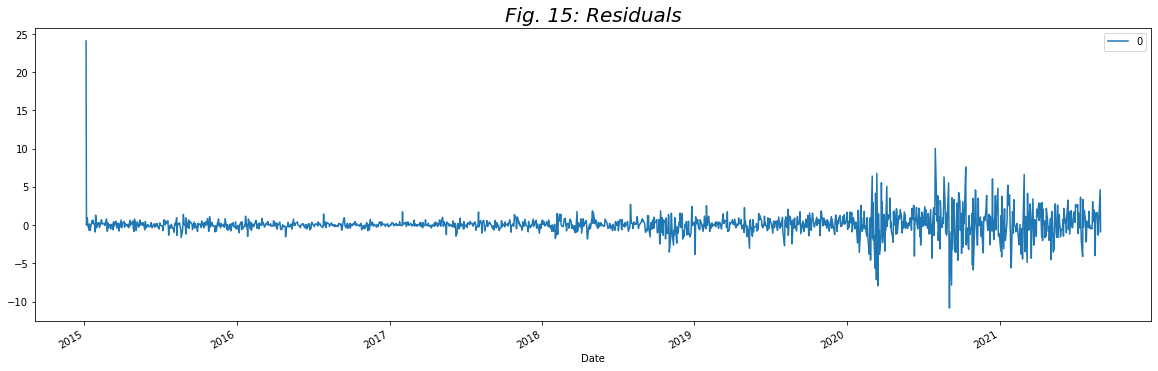

In [55]:
# plot the residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title("Fig. 15: Residuals", fontsize=20, fontstyle = 'italic')
plt.show()

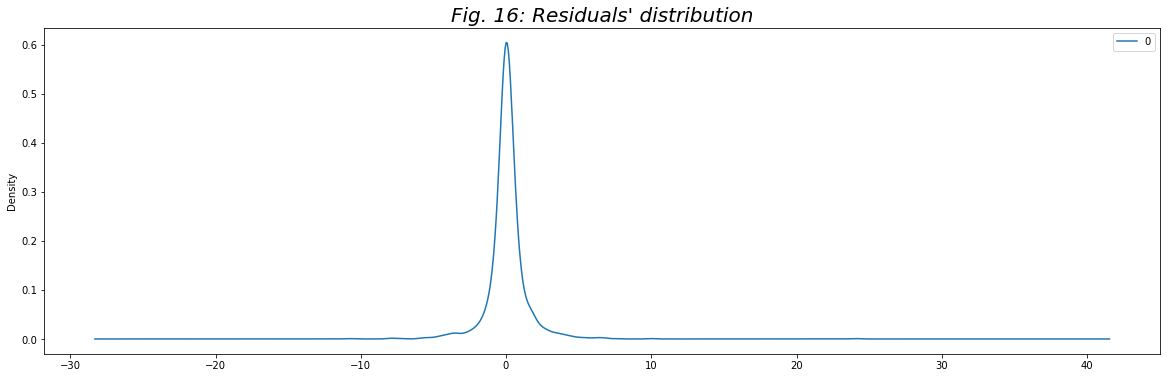

In [57]:
# density plot of residuals
residuals.plot(kind='kde')
plt.title("Fig. 16: Residuals' distribution", fontsize=20, fontstyle = 'italic')
plt.show()

In [19]:
# summary stats of residuals
print(residuals.describe())

                 0
count  1677.000000
mean      0.096831
std       1.430368
min     -10.839416
25%      -0.302884
50%       0.047218
75%       0.441301
max      24.083958


In [20]:
# predictions

# split into train and test sets
V = apple['Close'].values
size = int(len(V) * 0.9)
train, test = V[0:size], V[size:]
history = [v for v in train]
predictions = list()

predictions_updown = list()
real_updown = list()

In [21]:
# walk-forward validation

prev_price = train[-1]
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    predictions_updown.append(yhat - prev_price)
    real_updown.append(test[t] - prev_price)
    obs = test[t]
    history.append(obs)
    if t+1 < len(test):
        prev_price = test[t+1]
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=133.170572, expected=132.069473
predicted=132.184897, expected=128.804825
predicted=129.192036, expected=130.397324
predicted=130.111851, expected=126.007957
predicted=126.649580, expected=130.307755
predicted=129.558069, expected=131.432465
predicted=131.439505, expected=128.376831
predicted=128.797907, expected=128.197662
predicted=128.144586, expected=130.277893
predicted=130.003981, expected=128.307175
predicted=128.624354, expected=126.545425
predicted=126.733742, expected=127.232201
predicted=127.108624, expected=131.412567
predicted=130.867989, expected=136.229919
predicted=135.720818, expected=138.419647
predicted=138.259267, expected=142.251633
predicted=141.843453, expected=142.490524
predicted=142.560105, expected=141.395660
predicted=141.505506, expected=136.448898
predicted=136.977134, expected=131.342880
predicted=131.729736, expected=133.512680
predicted=133.182737, expected=134.358719
predicted=134.353088, expected=133.313644
predicted=133.423719, expected=136

In [22]:
# hit ratio

correct_count = 0
for i in range(len(real_updown)):
    if ((real_updown[i] > 0) and (predictions_updown[i] > 0)) or(( real_updown[i] <= 0) and (predictions_updown[i] <= 0)):
        correct_count += 1
    
print(correct_count / len(real_updown))

0.5119047619047619


In [23]:
# opposite of hit ratio

1 - (correct_count / len(real_updown))

0.48809523809523814

In [24]:
# evaluate forecasts

from sklearn.metrics import mean_squared_error
from math import sqrt

MSE = mean_squared_error(test,predictions)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % MSE)

# Test RMSE: 36.504 (0,66 train set)

Test RMSE: 2.134
Test MSE: 4.556


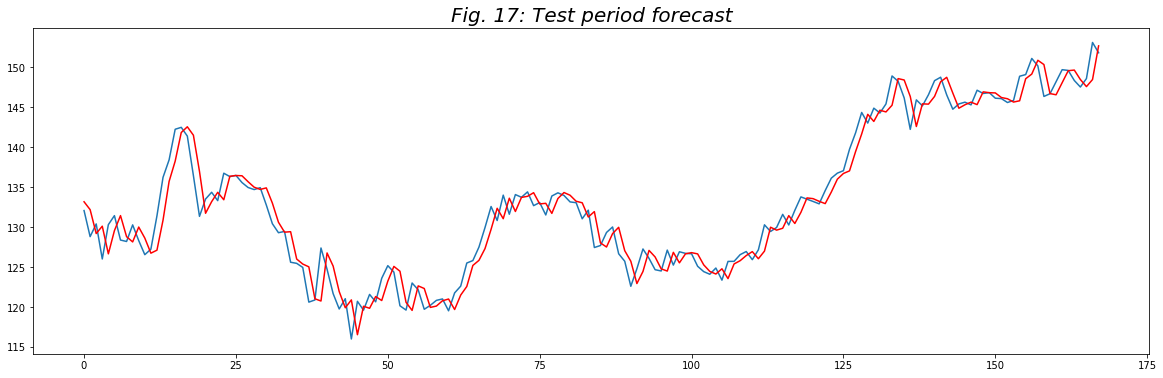

In [58]:
# plot forecasts against actual outcomes

plt.plot(test)
plt.plot(predictions, color='red')
plt.title("Fig. 17: Test period forecast", fontsize=20, fontstyle = 'italic')
plt.show()

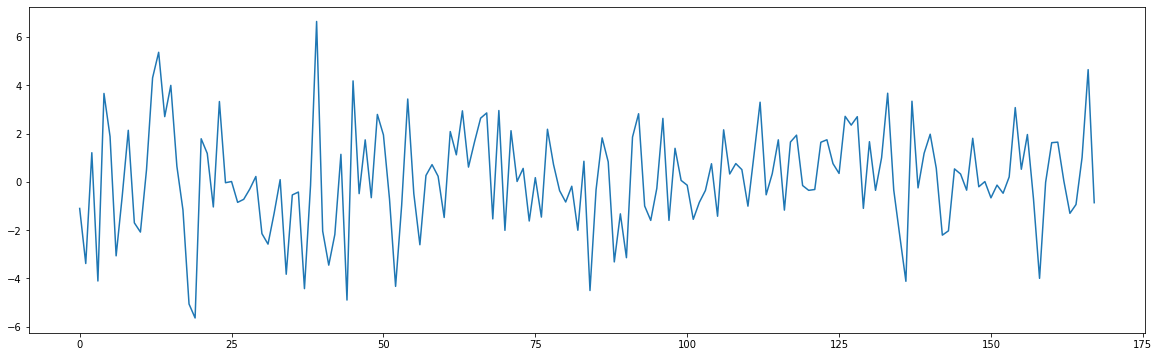

In [26]:
# plot residuals

plt.plot(test - predictions)
plt.show()

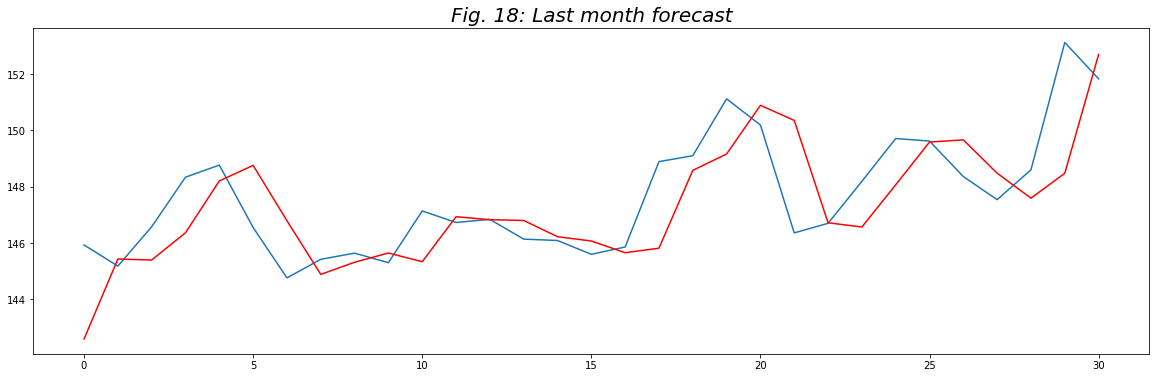

In [60]:
# smaller timeframe (31 days)

plt.plot(test[-31:])
plt.plot(predictions[-31:], color='red')
plt.title("Fig. 18: Last month forecast", fontsize=20, fontstyle = 'italic')
plt.show()